# COMPAS Analysis using Aequitas
In 2016, Propublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based off of [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset, found in the Propublica repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the widest used risk assessment tools, algorithms which are used in the criminal justice system to guide decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

Analysis by Ari Anisfeld and Abby Stevens.

In [3]:
import sys
sys.executable

'/Users/lorenh/Documents/DSaPP/.aequitas/bin/python3.6'

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import re
import math

%matplotlib inline

/Users/lorenh/Documents/DSaPP/.aequitas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
df = pd.read_csv("../../../examples/data/compas_for_aequitas.csv")
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


The data was preprocessed for compatibility with Aequitas. Notice the mandatory `score` and `label_value` columns along with a set of attribute columns specific to this data set. See [documentation](../input_data.html) for more information about input data. (`entity_id` is not necessary for this example. As a reserve column name, Aequitas will not treat `entity_id` as an attribute column.) 

## Exploratory Analysis

__Risk assessment by race__

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of low risk according to COMPAS, while a 1 indicates high or medium risk.

This is based on ProPublica's interpretation of Northpointe's practioner guide.

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range garner more interest from supervision agencies than low scores, as a low score would suggest there is little risk of general recidivism,” so we considered scores any higher than “low” to indicate a risk of recidivism."

In the bar chart below, we see a large difference in how these scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk.



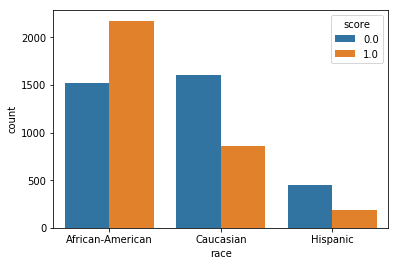

In [6]:
g = sns.countplot(x="race", hue="score", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])])

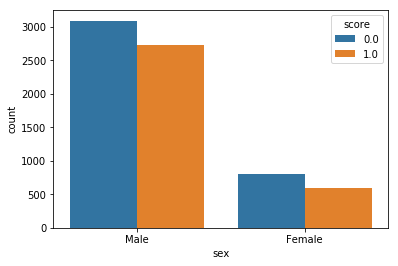

In [7]:
g = sns.countplot(x="sex", hue="score", data=df)

We note that for people under 25, COMPAS predicts higher risk at a higher rate for this younger age group than older age groups.

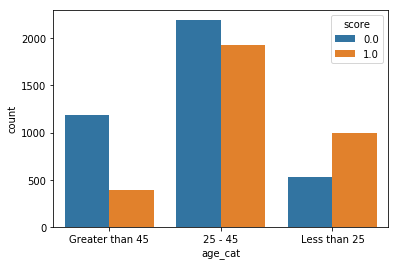

In [8]:
g = sns.countplot(x="age_cat", hue="score", data=df)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"


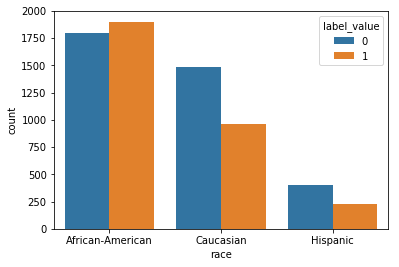

In [9]:
g = sns.countplot(x="race", hue="label_value", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])])

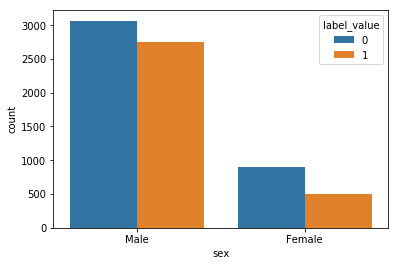

In [10]:
g = sns.countplot(x="sex", hue="label_value", data=df)

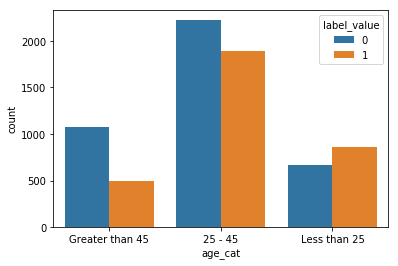

In [11]:
g = sns.countplot(x="age_cat", hue="label_value", data=df)

## Putting Aequitas to the task

The graph above shows the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39). The prior graph shows that the predictions do not match the base rates. 

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that we have multiple ways to measure bias adds complexity to the decisionmaking process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Group()
Aequitas expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this cases we include `race`, `sex` and `age_cat`. 

In [12]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [3317]}
COUNTS::: race
African-American    3696
Asian                 32
Caucasian           2454
Hispanic             637
Native American       18
Other                377
dtype: int64
COUNTS::: sex
Female    1395
Male      5819
dtype: int64
COUNTS::: age_cat
25 - 45            4109
Greater than 45    1576
Less than 25       1529
dtype: int64


The `get_crosstabs()` command tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calcuated:

| Metric | Column Name |
| --- | --- |
| $True Positive Rate$ | 'tpr' |
| $True Negative Rate$ | 'tnr' |
| $False Omission Rate$ | 'for' |
| $False Discovery Rate$ | 'fdr' |
| $False Positive Rate$ | 'fpr' |
| $False Negative Rate$ | 'fnr' |
| $Negative Predictive Value$ | 'npv' |
| $Precision$ | 'precision' |
| $Predicted Positive Ratio_k$ | 'ppr' |
| $Predicted Positive Ratio_g$ | 'pprev' |
| $Prevalence$ | 'prev' |

In [15]:
xtab.style

,attribute_name,attribute_value,k,model_id,score_threshold,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_neg,group_label_pos,group_size,total_entities,prev
0,race,African-American,3317,1,binary 0/1,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1795,1901,3696,7214,0.51434
1,race,Asian,3317,1,binary 0/1,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,8,24,0.00241182,0.25,2,3,21,6,23,9,32,7214,0.28125
2,race,Caucasian,3317,1,binary 0/1,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,1488,966,2454,7214,0.393643
3,race,Hispanic,3317,1,binary 0/1,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.0572807,0.298273,87,129,318,103,405,232,637,7214,0.364207
4,race,Native American,3317,1,binary 0/1,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,12,6,0.00361773,0.666667,3,1,5,9,8,10,18,7214,0.555556
5,race,Other,3317,1,binary 0/1,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.0238167,0.209549,36,90,208,43,244,133,377,7214,0.352785
6,sex,Female,3317,1,binary 0/1,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,591,804,0.178173,0.423656,288,195,609,303,897,498,1395,7214,0.356989
7,sex,Male,3317,1,binary 0/1,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,3066,2753,5819,7214,0.473105
8,age_cat,25 - 45,3317,1,binary 0/1,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.46824,741,706,1479,1183,2220,1889,4109,7214,0.459723
9,age_cat,Greater than 45,3317,1,binary 0/1,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.25,181,285,897,213,1078,498,1576,7214,0.31599


In [623]:
def list_metrics(group_table):
    return [col for col in group_table.columns if col in ['fpr', 'fnr', 'tpr', 'tnr', 'for', 'fdr', 'npv', 'precision', 'ppr', 'pprev', 'prev']]

In [624]:
absolute_metrics = list_metrics(xtab)

In [625]:
# View subset of calculated absolute metrics 
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,0.02,0.21,0.35
6,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
7,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
8,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
9,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32


In [753]:
def plot_group_metric(group_table, group_metric, ax=None, ax_lim=None, title=True, label_dict=None):
    '''
    Plot a single group metric's absolute metrics
    :param group_table: A group table
    :param group_metric: The metric to plot. Must be a column in the group_table
    :param ax: A matplotlib Axis. If not passed a new figure will be created.
    :param title: Whether a title should be added to the plot. Default is True. 
    :param label_dict: Dictionary of replacement labels for data. Default is None.
    :return: matplotlib.Axis
    '''
    if any(group_table[group_metric].isnull()):
        raise IOError(f"Cannot plot {group_metric}, has NaN values.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    height_of_bar = 1
    attribute_names = group_table.attribute_name.unique()
    tick_indices = []
    next_bar_height = 0
    label_position_values = list(group_table[group_metric].values)

    lighter_coppers = truncate_colormap('PuBu', min_value=0, max_value=0.65)
    
    norm = colors.Normalize(vmin=group_table[group_metric].min(), vmax=group_table[group_metric].max())
    mapping = cm.ScalarMappable(norm=norm, cmap=lighter_coppers)

    # Lock absolute value metric plot x-axis to (0, 1)
    ax_lim = 1
    ax.set_xlim(0, ax_lim)
    
    for attribute_name in attribute_names:
        
        attribute_data = group_table.loc[
            group_table['attribute_name'] == attribute_name]
        values = attribute_data[group_metric].values
        
        attribute_indices = np.arange(next_bar_height,
                                      next_bar_height + attribute_data.shape[0],
                                      step=height_of_bar)
        attribute_tick_location = float((min(attribute_indices) + max(attribute_indices) + height_of_bar)) / 2
        
        
        h_attribute = ax.barh(attribute_indices,
                              width=values,
                              label= list(attribute_data['attribute_value'].values),
                              align='edge', edgecolor='grey')
        
        label_colors = []
        min_brightness = 0.55
        
        for (i, bar), val in zip(enumerate(h_attribute), values):
            my_col = mapping.to_rgba(val)
            bar.set_color(my_col)
            label_colors.append(brightness_threshold(my_col[:3], min_brightness, light_color=(1,1,1,1)))
        
        if label_dict:
            labels = [label if label not in label_dict.keys() else label_dict[label] for label in attribute_data['attribute_value'].values]
        else:
            labels = attribute_data['attribute_value'].values

        for y, label, value, text_color in zip(attribute_indices, labels, values, label_colors):
                next_position = label_position_values.pop(0)
                
                if ax_lim < 3:
                    CHAR_PLACEHOLDER = 0.03
                else:
                    CHAR_PLACEHOLDER = 0.25
                    
                label_length = len(label) * CHAR_PLACEHOLDER
                max_val_length = 7 * CHAR_PLACEHOLDER
                indent_length = ax_lim * 0.025
                
                if ((indent_length + label_length) < (next_position - indent_length)) & ((next_position + indent_length + max_val_length) < (ax_lim - indent_length)):
                    # bar long enough for label, enough space after bar for value
                    ax.text(next_position + (ax_lim * 0.05), y + float(height_of_bar) / 2, 
                        f"{value:.2f}", fontsize=12, verticalalignment='top')
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        label, fontsize=11, verticalalignment='top', color=text_color)
                   
                elif (next_position + indent_length + max_val_length) > (ax_lim - indent_length):
                     # case when bar too long for labels after bar, print all text in bar
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=11, verticalalignment='top', color=text_color)
                
                else:
                    # case when bar too small for labels inside bar, print all text after bar
                    ax.text(next_position + indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=12, verticalalignment='top')
    
        tick_indices.append((attribute_name, attribute_tick_location))
        next_bar_height = max(attribute_indices) + 2 * height_of_bar

    ax.yaxis.set_ticks(list(map(lambda x: x[1], tick_indices)))
    ax.yaxis.set_ticklabels(list(map(lambda x: x[0], tick_indices)), fontsize=14)
    ax.set_xlabel("Absolute Metric Magnitude")

    if title:
        ax.set_title(f"{group_metric.upper()}", fontsize=20)
        
    return ax

# fix absolute group metrics to 1

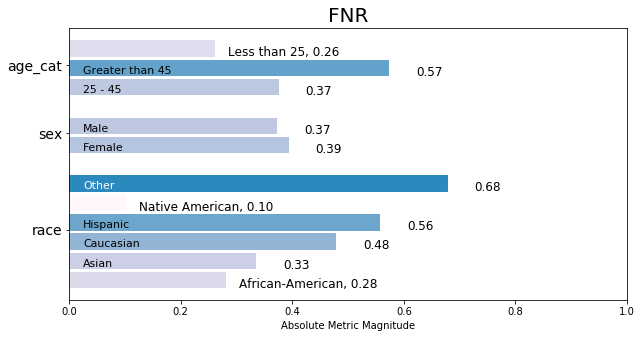

In [754]:
g = plot_group_metric(xtab, 'fnr')

In [756]:
def plot_group_metric_all(group_table, plot_group_metrics=None, ax_lim = None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    """
    This function plots absolute metrics as indicated by the config file
    :param group_table: Output of bias.get_disparity functions
    :param plot_group_metrics: which metrics to plot.
        If this value is null will plot all self.input_group_metrics
    :param fillzeros: Should null values be filled with zeros. Default is True
    :param title: Whether a title should be added to the plot. Default is True. 
    :param label_dict: (Optional) Dictionary of replacement values for data. Default is None.
    :param show_figure: Whether to show figure (plt.show()). Default is True.
    :return: Returns a figure
    """
    if fillzeros:
        group_table = group_table.fillna(0)

     # if user chooses to plot absolute metrics vs. disparity values:
    if not plot_group_metrics:
        plot_group_metrics = ['pprev', 'ppr', 'fdr', 'for','fpr','fnr']

    elif plot_group_metrics == 'all':
        plot_group_metrics = ['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 
                              'npv', 'precision', 'ppr', 'pprev']
 
    num_metrics = len(plot_group_metrics)
    rows = math.ceil(num_metrics / ncols)
    if ncols == 1 or (num_metrics % ncols == 0):
        axes_to_remove = 0
    else:
        axes_to_remove = ncols - (num_metrics % ncols)
    
    assert (0 < rows <= num_metrics),"Plot must have at least one row. Please update number of columns ('ncols') or list of metrics to be plotted ('plot_group_metrics')."
    assert (0 < ncols <= num_metrics),"Plot must have at least one column, and no more columns than metrics. Please update number of columns ('ncols') or list of metrics to be plotted ('plot_group_metrics')."
    
    total_plot_width = 25
    
    fig, axs = plt.subplots(nrows=rows, ncols=ncols, figsize=(total_plot_width, 6 * rows), sharey=True, gridspec_kw={'wspace':0.075, 'hspace':0.25})
    ax_lim = 1
    
    # set a different metric to be plotted in each subplot
    ax_col = 0
    ax_row = 0
    
    for group_metric in plot_group_metrics:    
        if (ax_col >= ncols) & ((ax_col + 1) % ncols) == 1:
            ax_row += 1
            ax_col = 0

        if rows == 1:
            current_subplot = axs[ax_col]
        
        elif ncols == 1:
            current_subplot = axs[ax_row]
            ax_row += 1
        else:
            current_subplot = axs[ax_row, ax_col]

        plot_group_metric(group_table, group_metric=group_metric,
                            ax=current_subplot, ax_lim=1, title=title, 
                            label_dict=label_dict)
        ax_col += 1

    # disable axes not being used
    if axes_to_remove > 0:
        for i in np.arange(axes_to_remove):
            axs[-1, -(i+1)].axis('off')
    
    if show_figure:
        plt.show()
    return fig

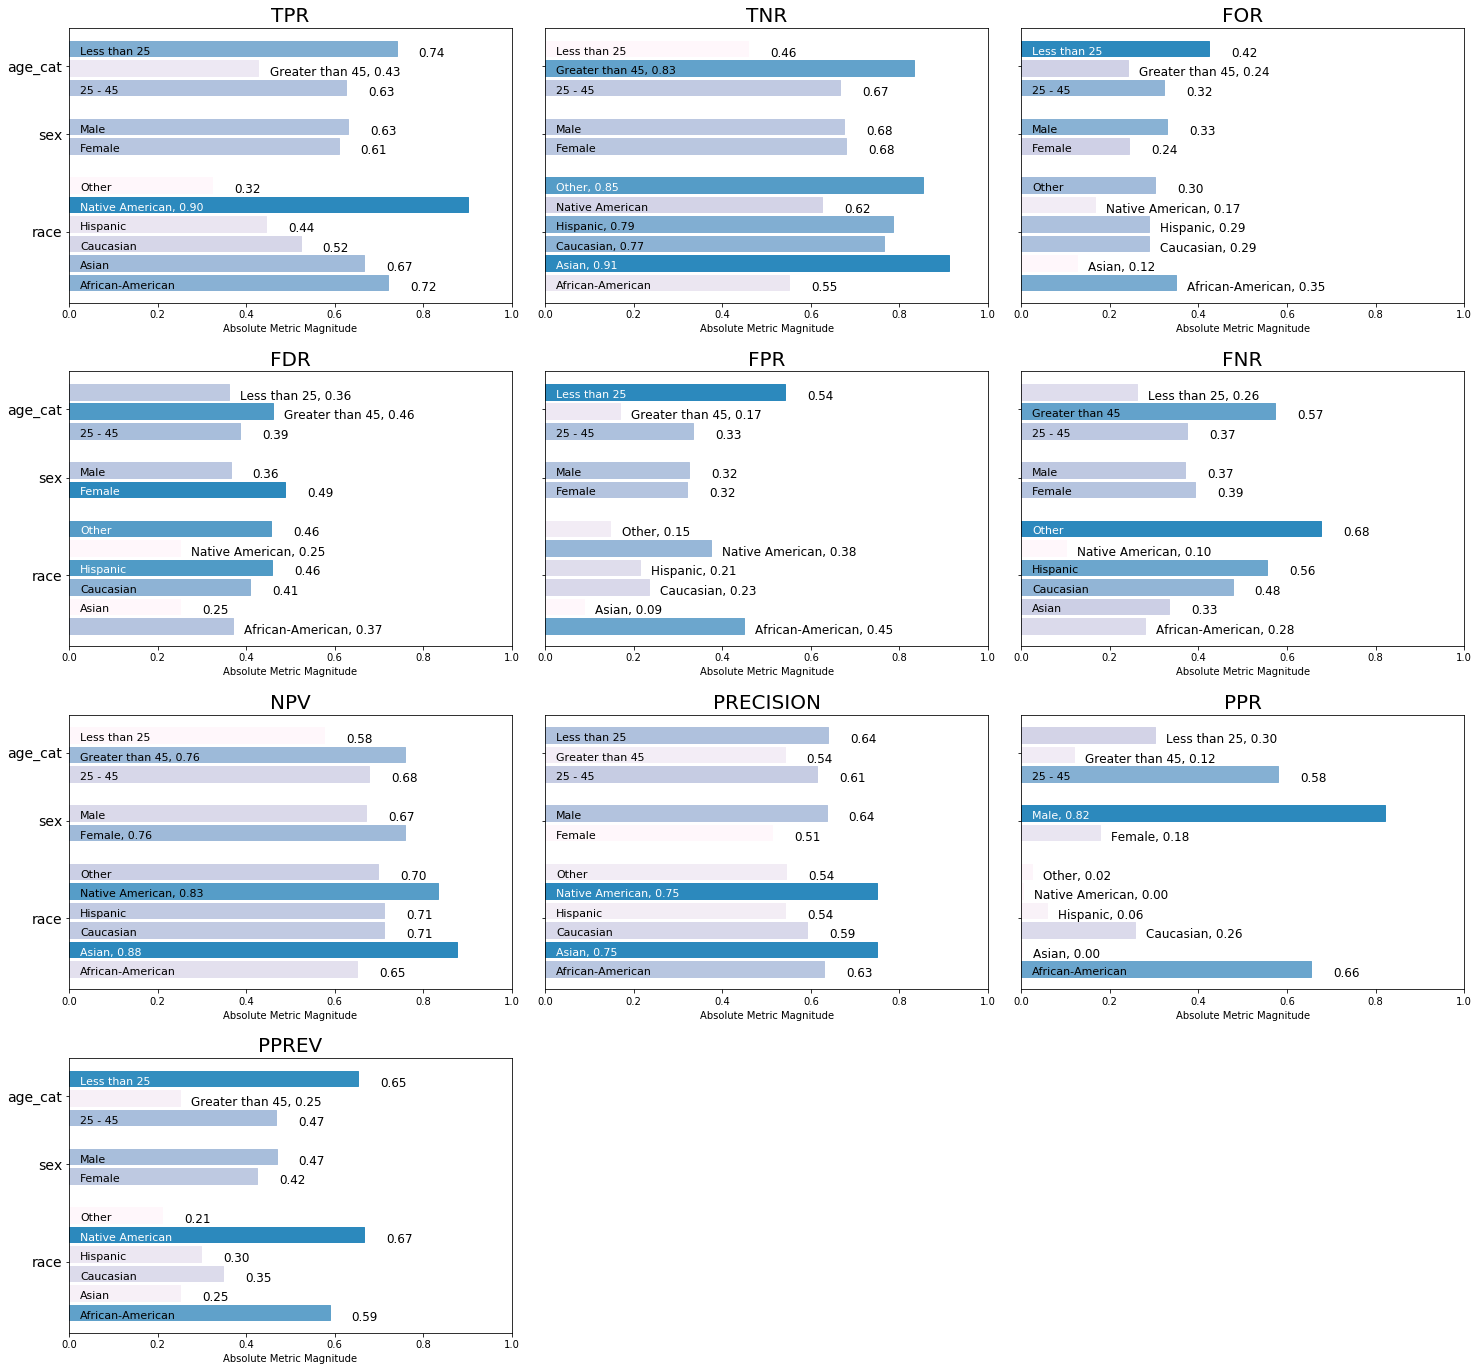

In [757]:
a = plot_group_metric_all(xtab, plot_group_metrics='all', ncols=3)

In [801]:
def plot_group_metric_all(data_table, plot_group_metrics=None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    return plot_multiple(data_table, plot_fcn=plot_group_metric, plot_group_metrics=plot_group_metrics, fillzeros=fillzeros, title=title, ncols=ncols, label_dict=label_dict, show_figure=show_figure)

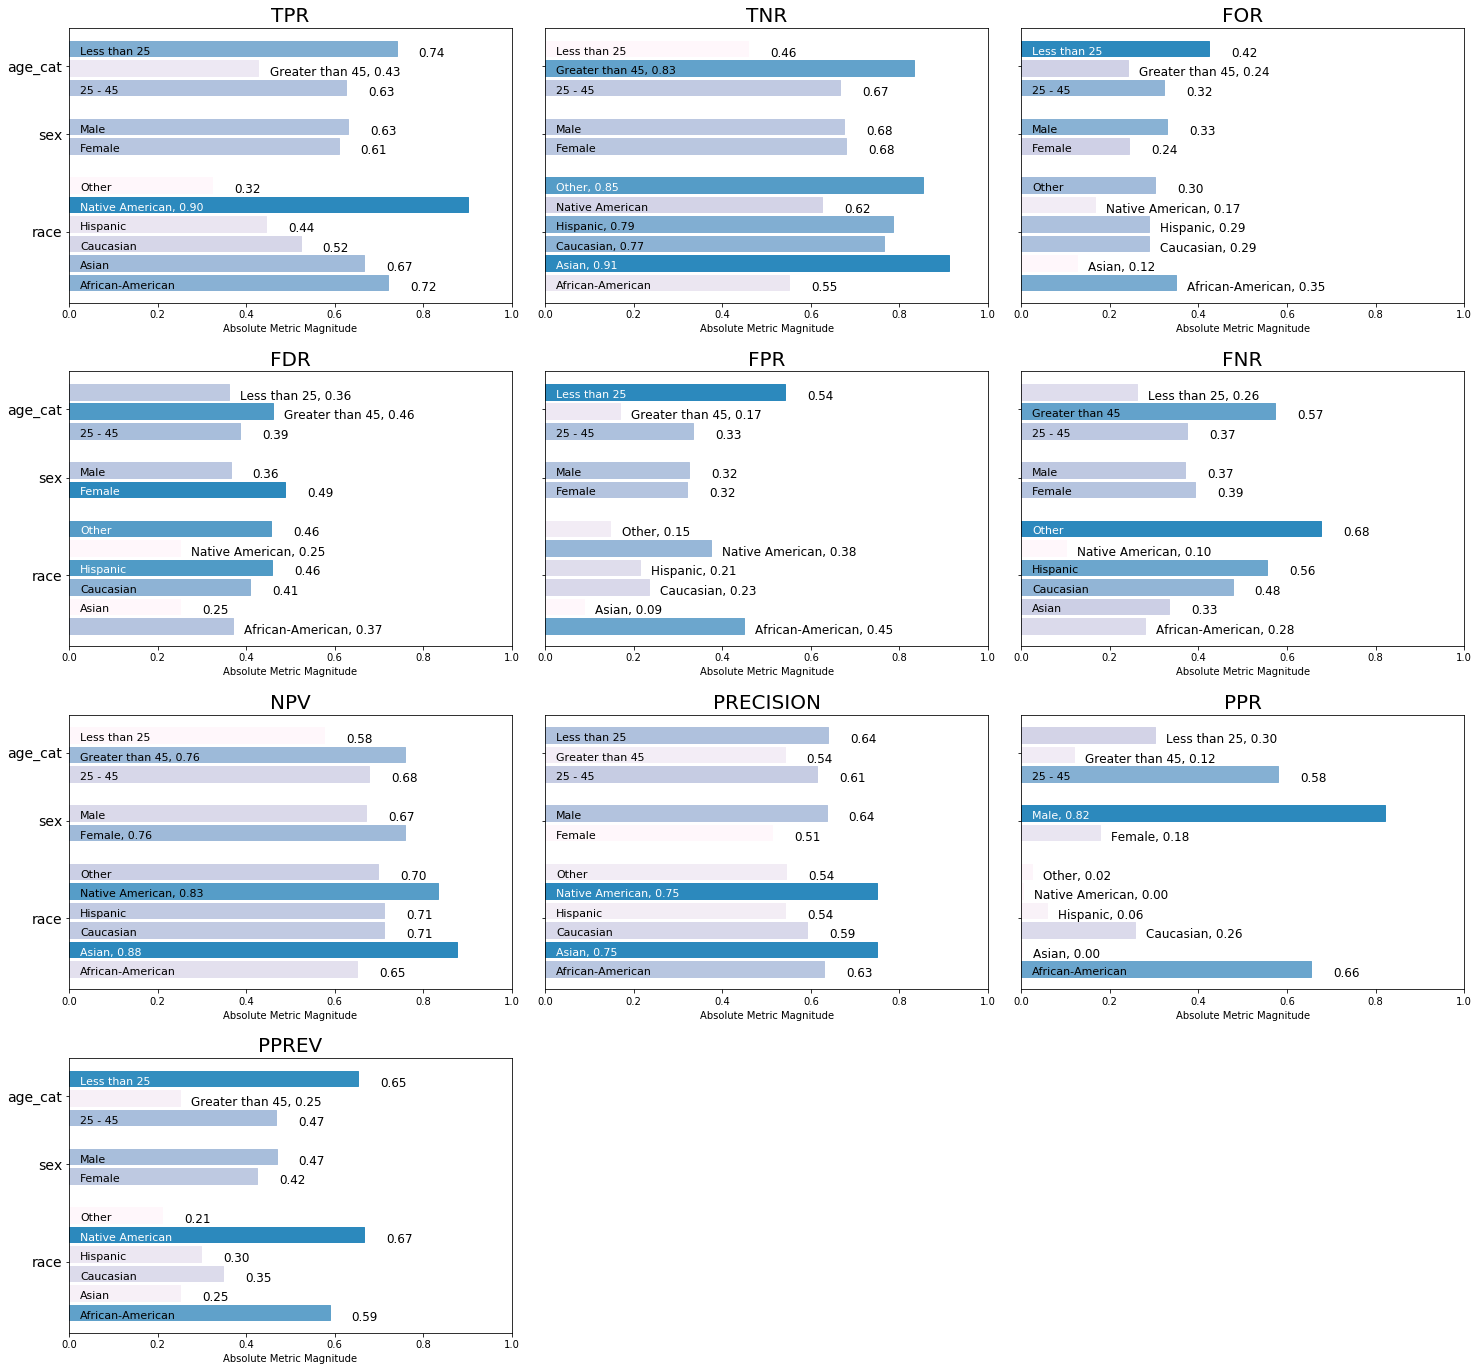

In [803]:
p = plot_group_metric_all(xtab, plot_group_metrics='all')

__Interpreting the crosstab__ 
We see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that black people are far more likely to be falsely labeled as high-risk than white people. On the otherhand false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

### Bias()
We calculate disparities as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use `get_disparity_predefined_groups` which allows us to choose reference groups that clarify the output for the practitioner. Aequitas `Bias()` class includes two additional get disparity functions, which automate base group selection.


In [23]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, {'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


In [24]:
majority_bdf = b.get_disparity_major_group(xtab)

get_disparity_major_group()


In [25]:
majority_bdf = b.get_disparity_major_group(xtab)

get_disparity_major_group()


In [26]:
min_metric_bdf = b.get_disparity_min_metric(xtab)

get_disparity_min_metric()
get_disparity_min_metric


The results are appended to the crosstab dataframe. We see a slice of this below.

In [618]:
def list_disparities(disparities_table):
    return list(disparities_table.columns[disparities_table.columns.str.contains('disparity')])

In [619]:
calculated_disparities = list_disparities(bdf)
calculated_disparities

['ppr_disparity',
 'pprev_disparity',
 'precision_disparity',
 'fdr_disparity',
 'for_disparity',
 'fpr_disparity',
 'fnr_disparity',
 'tpr_disparity',
 'tnr_disparity',
 'npv_disparity']

In [620]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728
1,race,Asian,0.009368,0.718384,1.268317,0.611748,0.433839,0.370749,0.698482,1.275248,1.192808,1.229148
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Hispanic,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346
4,race,Native American,0.014052,1.915691,1.268317,0.611748,0.578453,1.598854,0.209544,1.721584,0.816506,1.170618
5,race,Other,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490
6,sex,Female,0.216801,0.904348,0.806925,1.336425,0.734738,0.990343,1.055810,0.967101,1.004633,1.130710
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,age_cat,Greater than 45,0.204782,0.533914,0.879232,1.192804,0.746232,0.503031,1.531238,0.682963,1.248989,1.121136


__Interpreting the disparity ratios__
The differences in False Positive Rates, noted above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people. As seen above, False Discovery Rates have much less disparity (`fdr_disparity`). False discovery is the fraction of false postives over predicted positive in a group. COMPAS is calibrated to have these balanced across groups.

Notice that reference groups have disparity = 1 by design. 

In [30]:
# Must add to Bias class
def nearest_quartile(x):
    rounded = round(x*4)/4
    if rounded > x:
        return rounded
    else:
        return rounded + 1/4

In [31]:
def truncate_colormap(orig_cmap, min_value=0.0, max_value=1.0, num_colors=100):
    '''
    Use only part of a colormap. 
    Attribution: Adapted from: https://stackoverflow.com/questions/
    18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    '''
    cmap = plt.get_cmap(orig_cmap)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=min_value, b=max_value),
        cmap(np.linspace(min_value, max_value, num_colors)))
    return new_cmap

In [114]:
def check_brightness(rgb_tuple):
    '''
    Determine the brightness of background color. 
    Adapted from https://trendct.org/2016/01/22/how-to-choose-a-label-color-to-contrast-with-background/
    '''
    r, g, b = rgb_tuple
    return (r * 299 + g * 587 + b * 114) / 1000


def brightness_threshold(rgb_tuple, min_brightness, light_color, dark_color='black'):
    '''
    Determine ideal label color based on brightness of background color. 
    Adapted from https://trendct.org/2016/01/22/how-to-choose-a-label-color-to-contrast-with-background/
    '''
    if check_brightness(rgb_tuple) > min_brightness:
        return dark_color
    
    return light_color

In [739]:
def plot_disparity(disparities_table, group_metric, ax=None, ax_lim = None, title=True, label_dict=None):
    '''
    Plot a single group metric's disparity
    :param disparities_table: A disparity table
    :param group_metric: The metric to plot. Must be a column in the disparities_table
    :param ax: A matplotlib Axis. If not passed a new figure will be created.
    :param ax_lim: The x-axis maximum value. Default is None.
    :param title: Whether a title should be added to the plot. Default is True. 
    :param label_dict: Dictionary of replacement labels for data. Default is None.
    :return: matplotlib.Axis
    '''
    if any(disparities_table[group_metric].isnull()):
        raise IOError(f"Cannot plot {group_metric}, has NaN values.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    height_of_bar = 1
    attribute_names = disparities_table.attribute_name.unique()
    tick_indices = []
    next_bar_height = 0
    label_position_values = list(disparities_table[group_metric].values)

    lighter_coppers = truncate_colormap('copper_r', min_value=0, max_value=0.65)
    
    norm = colors.Normalize(vmin=disparities_table[group_metric].min(), vmax=disparities_table[group_metric].max())
    mapping = cm.ScalarMappable(norm=norm, cmap=lighter_coppers)
    
    if not ax_lim:
        ax_lim = nearest_quartile(disparities_table[group_metric].max()) + 0.1
    
    ax.set_xlim(0, min(10, ax_lim))
    
    for attribute_name in attribute_names:
        
        attribute_data = disparities_table.loc[
            disparities_table['attribute_name'] == attribute_name]
        values = attribute_data[group_metric].values
        
        attribute_indices = np.arange(next_bar_height,
                                      next_bar_height + attribute_data.shape[0],
                                      step=height_of_bar)
        attribute_tick_location = float((min(attribute_indices) + max(attribute_indices) + height_of_bar)) / 2
        
        
        h_attribute = ax.barh(attribute_indices,
                              width=values,
                              label= list(attribute_data['attribute_value'].values),
                              align='edge', edgecolor='grey')
        
        label_colors = []
        min_brightness = 0.55
        
        for (i, bar), val in zip(enumerate(h_attribute), values):
            my_col = mapping.to_rgba(val)
            bar.set_color(my_col)
            label_colors.append(brightness_threshold(my_col[:3], min_brightness, light_color=(1,1,1,1)))
        
        if label_dict:
            labels = [label if label not in label_dict.keys() else label_dict[label] for label in attribute_data['attribute_value'].values]
        else:
            labels = attribute_data['attribute_value'].values

        for y, label, value, text_color in zip(attribute_indices, labels, values, label_colors):
                next_position = label_position_values.pop(0)
                
                if ax_lim < 3:
                    CHAR_PLACEHOLDER = 0.03
                else:
                    CHAR_PLACEHOLDER = 0.25
                    
                label_length = len(label) * CHAR_PLACEHOLDER
                max_val_length = 7 * CHAR_PLACEHOLDER
                indent_length = ax_lim * 0.025
                
                if ((indent_length + label_length) < (next_position - indent_length)) & ((next_position + indent_length + max_val_length) < (ax_lim - indent_length)):
                    # bar long enough for label, enough space after bar for value
                    ax.text(next_position + (ax_lim * 0.05), y + float(height_of_bar) / 2, 
                        f"{value:.2f}", fontsize=12, verticalalignment='top')
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        label, fontsize=11, verticalalignment='top', color=text_color)
                   
                elif (next_position + indent_length + max_val_length) > (ax_lim - indent_length):
                     # case when bar too long for labels after bar, print all text in bar
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=11, verticalalignment='top', color=text_color)
                
                else:
                    # case when bar too small for labels inside bar, print all text after bar
                    ax.text(next_position + indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=12, verticalalignment='top')
    
        tick_indices.append((attribute_name, attribute_tick_location))
        next_bar_height = max(attribute_indices) + 2 * height_of_bar

    ax.yaxis.set_ticks(list(map(lambda x: x[1], tick_indices)))
    ax.yaxis.set_ticklabels(list(map(lambda x: x[0], tick_indices)), fontsize=14)
    
    ax.set_xlabel('Disparity Magnitude')

    if title:
        ax.set_title(f"{group_metric.upper()}", fontsize=20)
        
    return ax

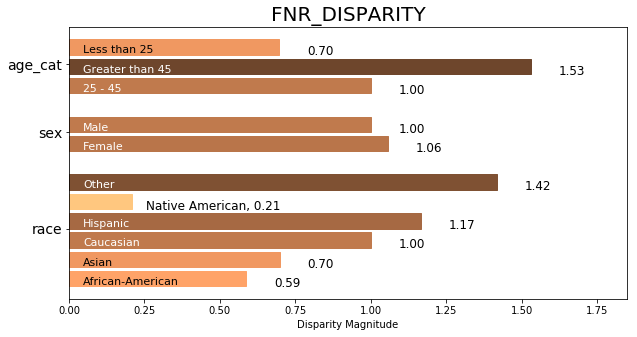

In [740]:
plot_disparity(bdf, 'fnr_disparity')
plt.show()

In [746]:
def plot_disparity_all(disparities_table, plot_group_metrics=None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    """
    This function plots disparities as indicated by the config file
    :param disparities_table: Output of bias.get_disparity functions
    :param plot_group_metrics: which metrics to plot.
        If this value is null will plot all self.input_group_metrics
    :param fillzeros: Should null values be filled with zeros. Default is True.
    :param title: Whether a title should be added to the plot. Default is True. 
    :param label_dict: (Optional) Dictionary of replacement values for data. Default is None.
    :param show_figure: Whether to show figure (plt.show()). Default is True.
    :return: Returns a figure
    """
    if fillzeros:
        disparities_table = disparities_table.fillna(0)

    # if user chooses to plot disparity values vs. absolute metrics
    if not plot_group_metrics:
#         plot_group_metrics = list(set(self.input_group_metrics) & set(disparities_table.columns))
        plot_group_metrics = ['pprev_disparity', 'ppr_disparity', 'fdr_disparity', 
                         'for_disparity','fpr_disparity','fnr_disparity']
    elif plot_group_metrics == 'all':
        plot_group_metrics = list(disparities_table.columns[disparities_table.columns.str.contains('disparity')])

    num_metrics = len(plot_group_metrics)
    rows = math.ceil(num_metrics / ncols)
    if (ncols == 1) or (num_metrics % ncols == 0):
        axes_to_remove = 0
    else:
        axes_to_remove = ncols - (num_metrics % ncols)
    
    assert (0 < rows <= num_metrics),"Plot must have at least one row. Please update number of columns ('ncols') or list of metrics to be plotted ('plot_group_metrics')."
    assert (0 < ncols <= num_metrics),"Plot must have at least one column, and no more columns than metrics. Please update number of columns ('ncols') or list of metrics to be plotted ('plot_group_metrics')."
        
    total_plot_width = 25
    
    fig, axs = plt.subplots(nrows=rows, ncols=ncols, figsize=(total_plot_width, 6 * rows), sharey=True, gridspec_kw={'wspace':0.075, 'hspace':0.25})
    ax_lim = min(10, nearest_quartile(max(disparities_table[plot_group_metrics].max())) + 0.1)
    
    # set a different metric to be plotted in each subplot
    ax_col = 0
    ax_row = 0
    
    for group_metric in plot_group_metrics:    
        if (ax_col >= ncols) & ((ax_col + 1) % ncols) == 1:
            ax_row += 1
            ax_col = 0

        if rows == 1:
            current_subplot = axs[ax_col]
        
        elif ncols == 1:
            current_subplot = axs[ax_row]
            ax_row += 1
        else:
            current_subplot = axs[ax_row, ax_col]

        plot_disparity(disparities_table, group_metric=group_metric, 
                                         ax=current_subplot, title=title, 
                                         ax_lim = ax_lim, label_dict=label_dict)
        ax_col += 1
    
    # disable axes not being used
    if axes_to_remove > 0:
        for i in np.arange(axes_to_remove):
            axs[-1, -(i+1)].axis('off')

    if show_figure:
        plt.show()
    return fig

In [793]:
def plot_disparity_all(data_table, plot_group_metrics=None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    return plot_multiple(data_table, plot_fcn=plot_disparity, plot_group_metrics=plot_group_metrics, fillzeros=fillzeros, title=title, ncols=ncols, label_dict=label_dict, show_figure=show_figure)

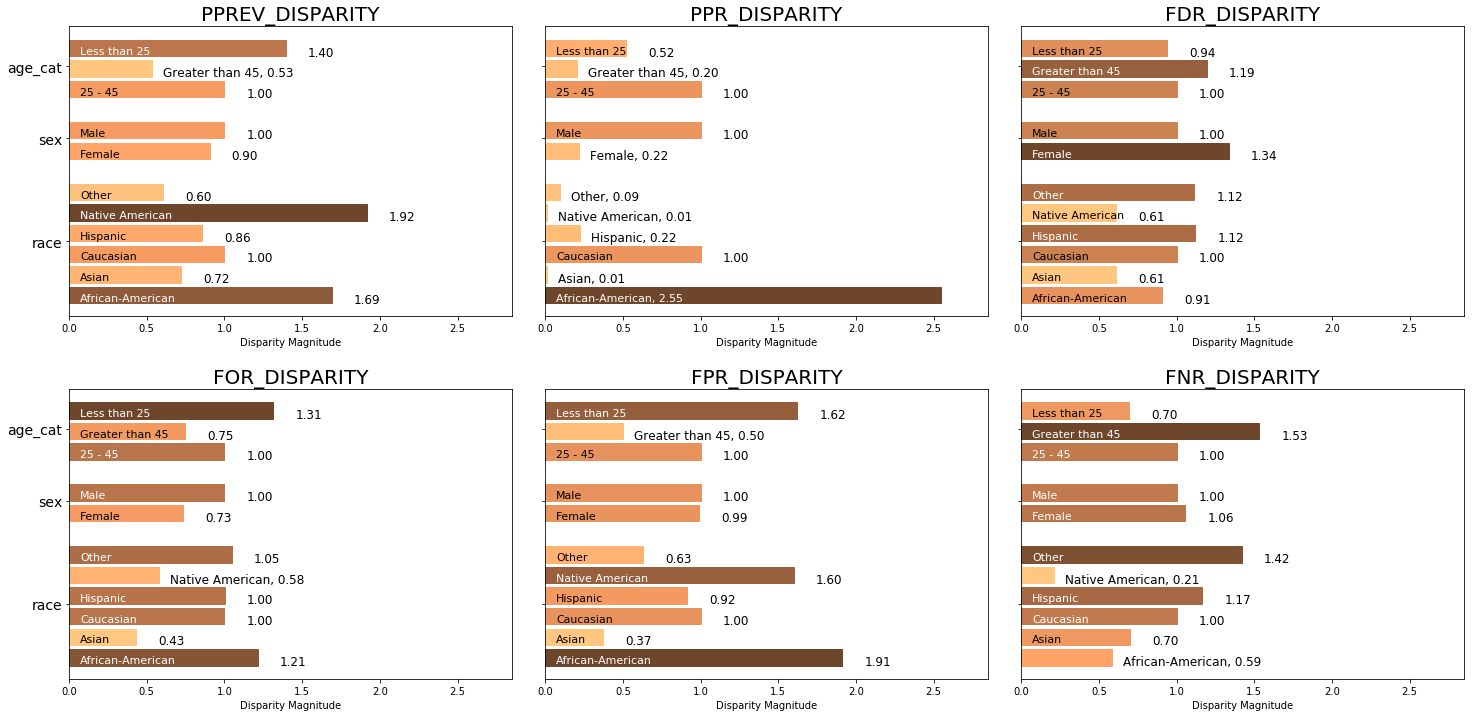

In [794]:
t = plot_disparity_all(bdf)

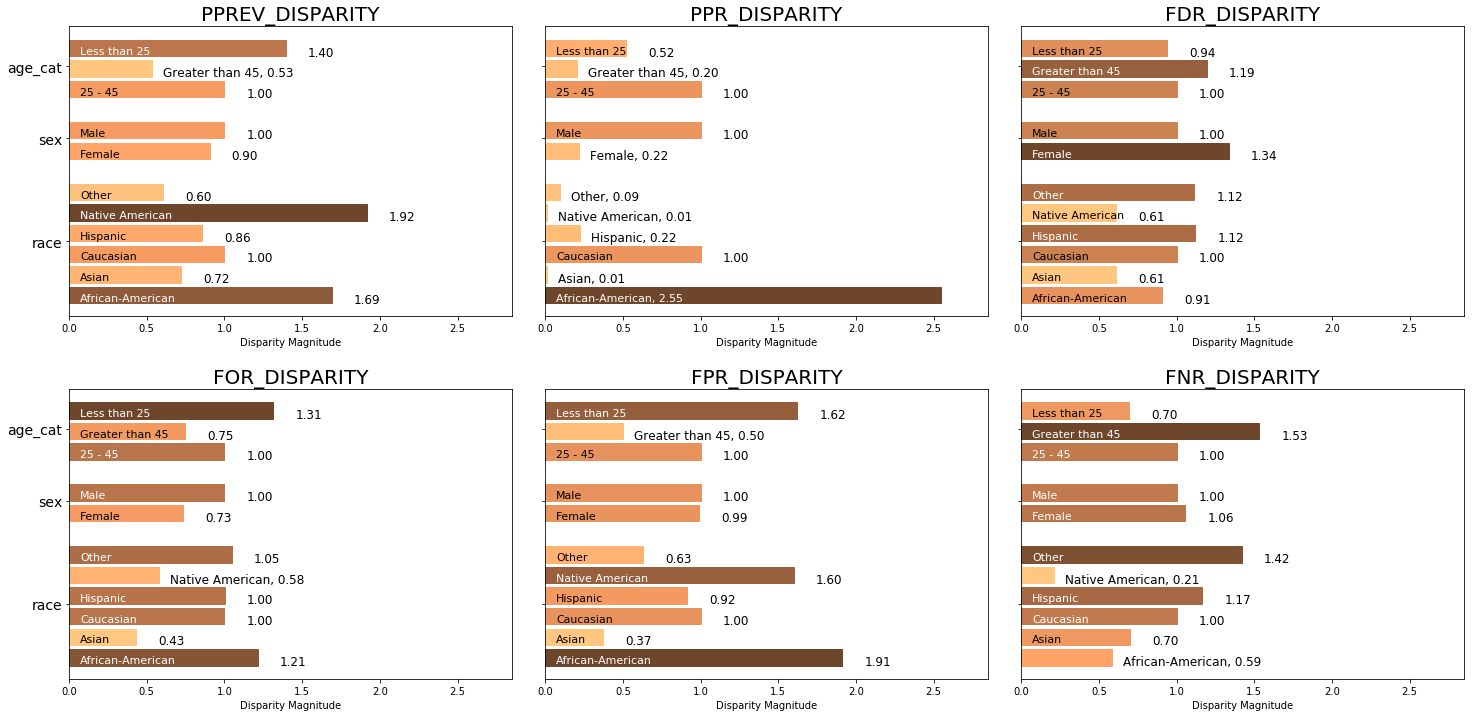

In [795]:
f = plot_disparity_all(bdf, ncols=3)
plt.show()

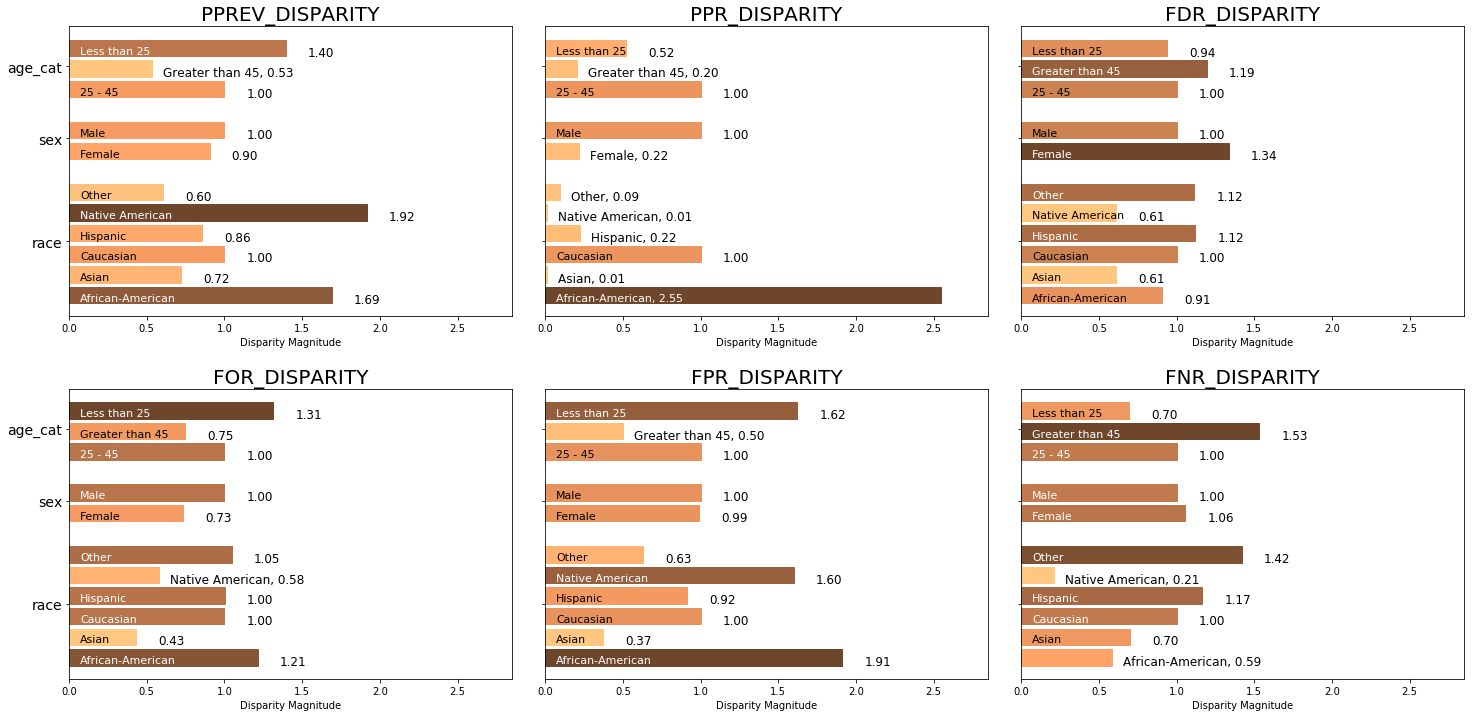

In [796]:
f = plot_disparity_all(bdf, ncols=3)
plt.show()

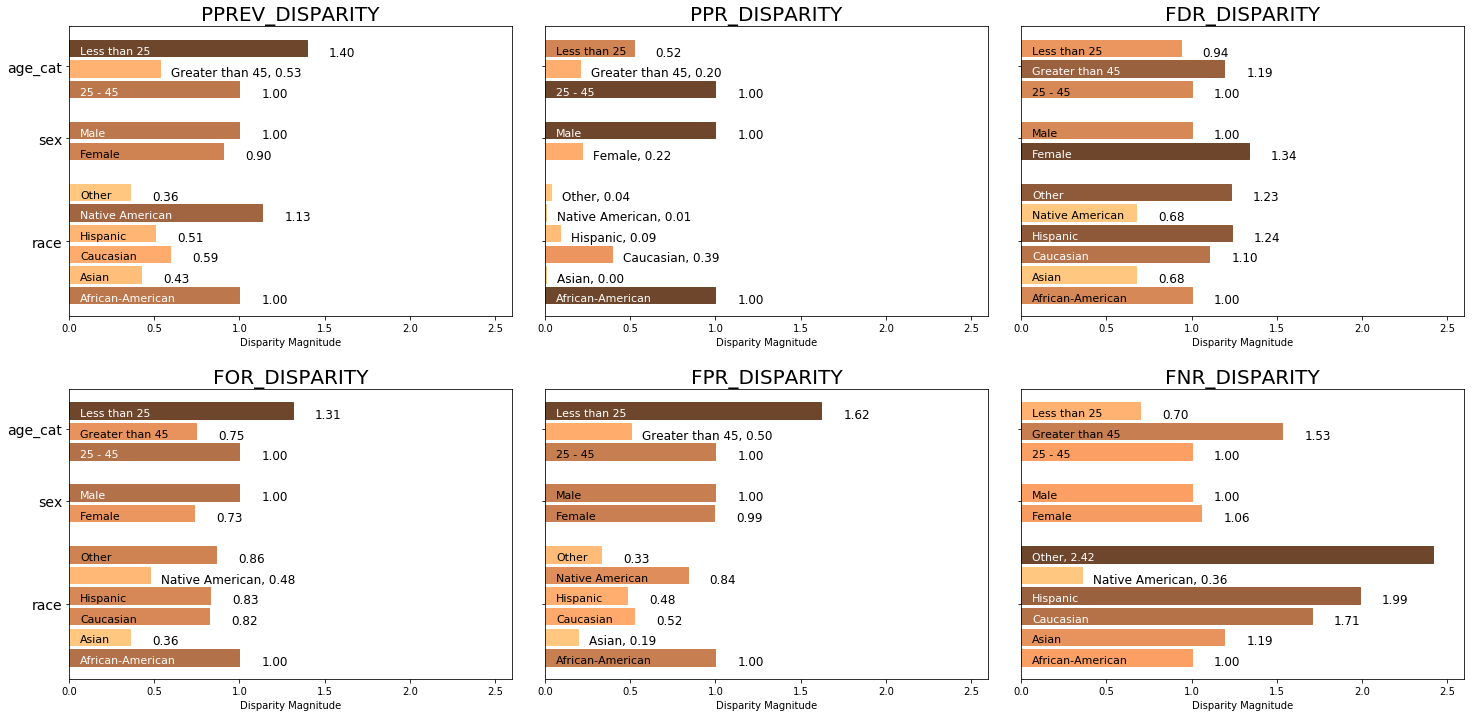

In [797]:
m = plot_disparity_all(majority_bdf, ncols=3)
plt.show()

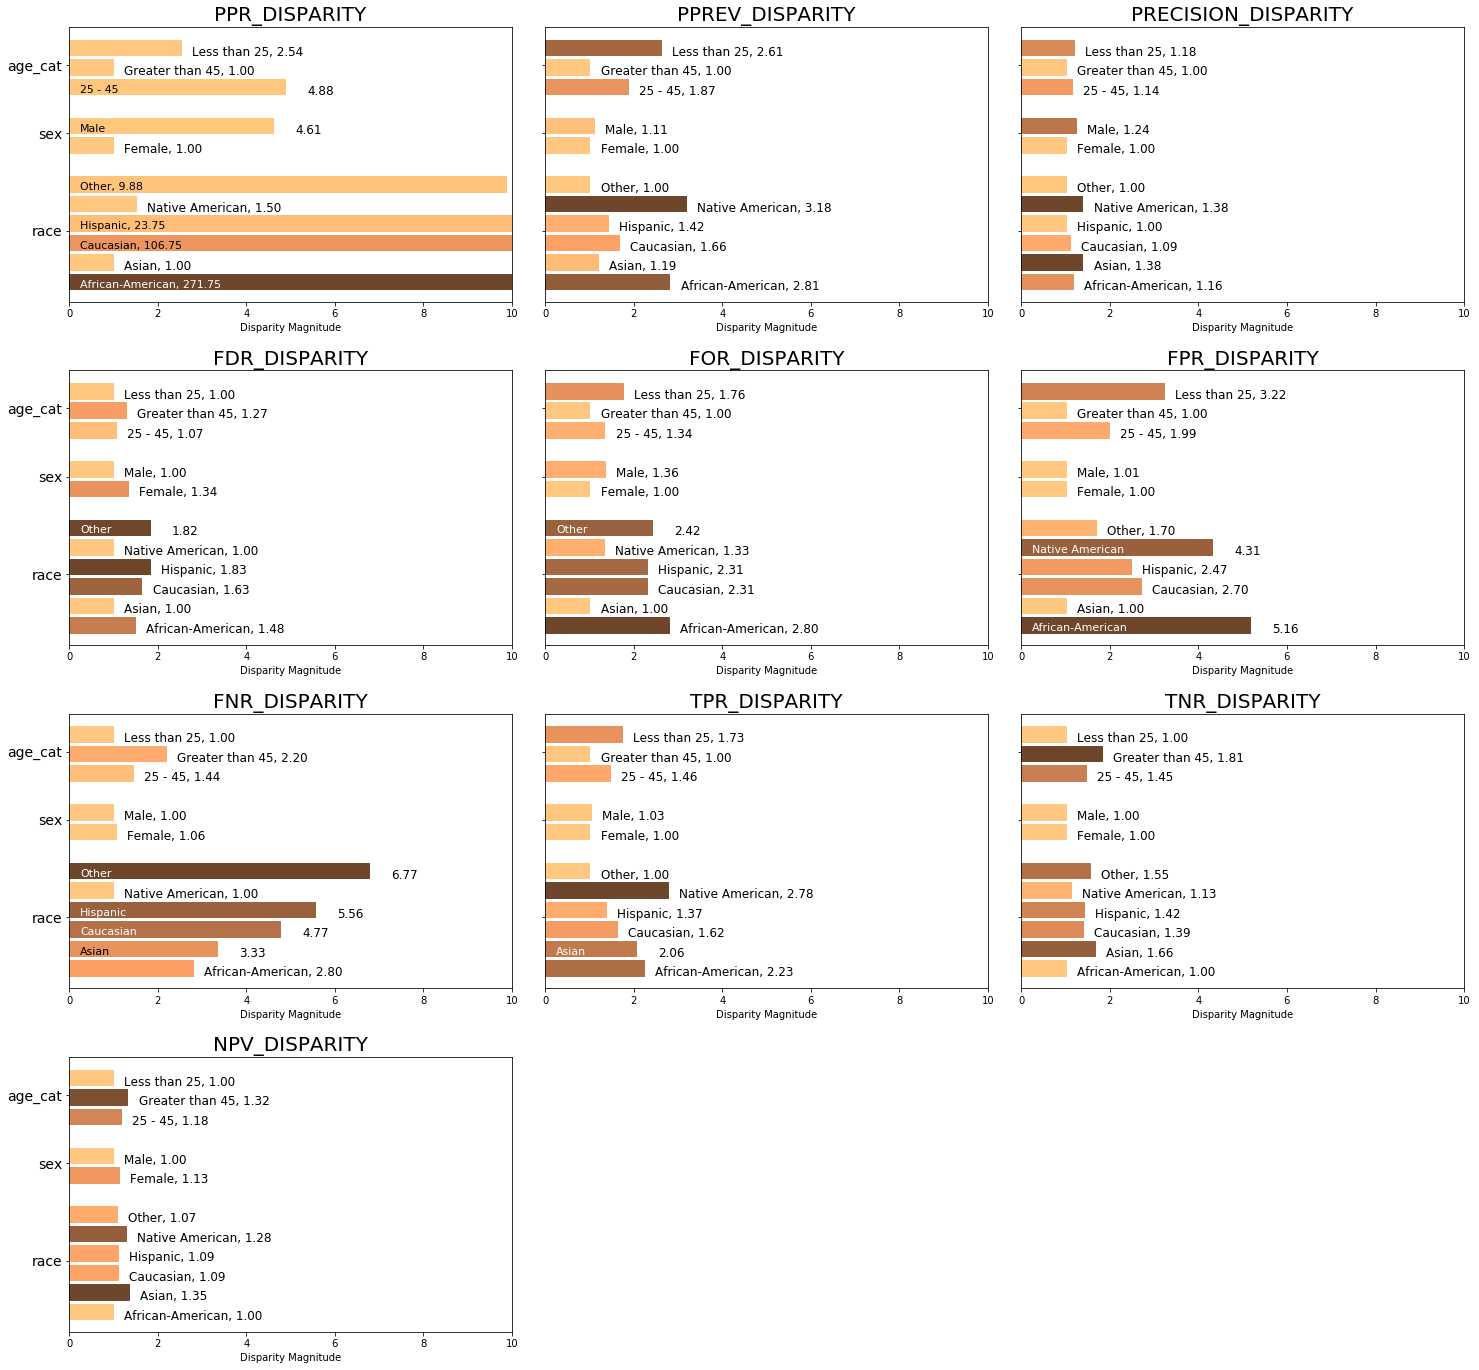

In [798]:
min_met = plot_disparity_all(min_metric_bdf, plot_group_metrics='all', ncols=3)

### Fairness()
Finally, the `Fairness()` class provides three functions that provide a high level summary. Using FPR disparity as an example and the default fairness threshold, we have:

$$ 0.8 < Disparity_{FNR} =  \frac{FPR_{group}}{FPR_{base group}} < 1.25 $$ 

The `Fairness().get_group_value_fairness()` function builds on the previous dataframe.


In [302]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [303]:
fdf.style

,attribute_name,attribute_value,k,model_id,score_threshold,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_neg,group_label_pos,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,race,African-American,3317,1,binary 0/1,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1795,1901,3696,7214,0.51434,2.54567,1.69022,1.0649,0.906085,1.21315,1.91209,0.586416,1.37755,0.720526,0.913728,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False
1,race,Asian,3317,1,binary 0/1,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,8,24,0.00241182,0.25,2,3,21,6,23,9,32,7214,0.28125,0.00936768,0.718384,1.26832,0.611748,0.433839,0.370749,0.698482,1.27525,1.19281,1.22915,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
2,race,Caucasian,3317,1,binary 0/1,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,1488,966,2454,7214,0.393643,1,1,1,1,1,1,1,1,1,1,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,3317,1,binary 0/1,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.0572807,0.298273,87,129,318,103,405,232,637,7214,0.364207,0.222482,0.857099,0.916748,1.12046,1.00162,0.915887,1.16514,0.849249,1.02577,0.999346,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
4,race,Native American,3317,1,binary 0/1,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,12,6,0.00361773,0.666667,3,1,5,9,8,10,18,7214,0.555556,0.0140515,1.91569,1.26832,0.611748,0.578453,1.59885,0.209544,1.72158,0.816506,1.17062,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
5,race,Other,3317,1,binary 0/1,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.0238167,0.209549,36,90,208,43,244,133,377,7214,0.352785,0.0925059,0.602147,0.920466,1.11508,1.0482,0.629057,1.41797,0.618447,1.11366,0.98049,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,True,True,True,False,False,False,False,False
6,sex,Female,3317,1,binary 0/1,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,591,804,0.178173,0.423656,288,195,609,303,897,498,1395,7214,0.356989,0.216801,0.904348,0.806925,1.33642,0.734738,0.990343,1.05581,0.967101,1.00463,1.13071,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False
7,sex,Male,3317,1,binary 0/1,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,3066,2753,5819,7214,0.473105,1,1,1,1,1,1,1,1,1,1,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,a

We can assess fairness at various levels of detail. 

In [304]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_cat,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,1,binary 0/1,race,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1,binary 0/1,sex,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False


In [305]:
gof = f.get_overall_fairness(gaf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

In [306]:
fairness_grid = fdf[['attribute_name', 'attribute_value','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOR Parity', 'FNR Parity',
       'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]

In [307]:
def true_false_highlight(value):
    '''
    Colors True and False values green and red, respectively.
    '''
    color = 'black'
    
    if (isinstance(value, bool)) & (value == True):
        color = 'green'
    elif (isinstance(value, bool)) & (value == False):
        color = 'red'

    return 'color: {}'.format(color)

In [308]:
def view_bias(df, base=None, disparities=False, parities=False, fairness=False, highlight_fairness=False):
    if not base:
        base = ['attribute_name', 'attribute_value', 'model_id', 'score_threshold']
    if disparities:
        base += list(df.columns[df.columns.str.contains('disparity')])
    if parities:
        base += list(df.columns[df.columns.str.contains('Parity')])
    if fairness:
        base += list(df.columns[df.columns.str.contains('Fairness|Equalized Odds')])
    if highlight_fairness:
        return df[base].style.applymap(true_false_highlight)
    else:
        return df.loc[:,base]

In [309]:
view_bias(fdf, disparities=True, parities=False, fairness=False, highlight_fairness=True)

,attribute_name,attribute_value,model_id,score_threshold,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,1,binary 0/1,2.54567,1.69022,1.0649,0.906085,1.21315,1.91209,0.586416,1.37755,0.720526,0.913728
1,race,Asian,1,binary 0/1,0.00936768,0.718384,1.26832,0.611748,0.433839,0.370749,0.698482,1.27525,1.19281,1.22915
2,race,Caucasian,1,binary 0/1,1,1,1,1,1,1,1,1,1,1
3,race,Hispanic,1,binary 0/1,0.222482,0.857099,0.916748,1.12046,1.00162,0.915887,1.16514,0.849249,1.02577,0.999346
4,race,Native American,1,binary 0/1,0.0140515,1.91569,1.26832,0.611748,0.578453,1.59885,0.209544,1.72158,0.816506,1.17062
5,race,Other,1,binary 0/1,0.0925059,0.602147,0.920466,1.11508,1.0482,0.629057,1.41797,0.618447,1.11366,0.98049
6,sex,Female,1,binary 0/1,0.216801,0.904348,0.806925,1.33642,0.734738,0.990343,1.05581,0.967101,1.00463,1.13071
7,sex,Male,1,binary 0/1,1,1,1,1,1,1,1,1,1,1
8,age_cat,25 - 45,1,binary 0/1,1,1,1,1,1,1,1,1,1,1
9,age_cat,Greater than 45,1,binary 0/1,0.204782,0.533914,0.879232,1.1928,0.746232,0.503031,1.53124,0.682963,1.24899,1.12114


In [310]:
def parity_count(df, base=None):
    '''
    Plot the count of parity measures acheived for each group.
    '''
    if not base:
        base = ['attribute_name', 'attribute_value', 'model_id', 'score_threshold']
    included_parities = list(df.columns[df.columns.str.contains('Parity')])
    
    num_models = len(df['model_id'].unique())
    fig, axs = plt.subplots(figsize=(7, 5))
    
    for model in df['model_id'].unique():
        parity_df = view_bias(df, parities=True)
        parity_df.loc[:,'parity_sum'] = df[included_parities].sum(axis=1)
        parity_df.set_index(['attribute_value'], inplace=True)

        norm = colors.Normalize(vmin=parity_df['parity_sum'].min(), vmax=parity_df['parity_sum'].max())
        mapping = cm.ScalarMappable(norm=norm, cmap='Greys')

        bars = plt.barh(y=parity_df.index, width=parity_df['parity_sum'], edgecolor='grey')
        for (i, bar), parities in zip(enumerate(bars), parity_df['parity_sum']):
            my_col = mapping.to_rgba(parities)
            bar.set_color(my_col)
        plt.title(f"Parities Achieved, by Group, Model {model}")
        plt.show()

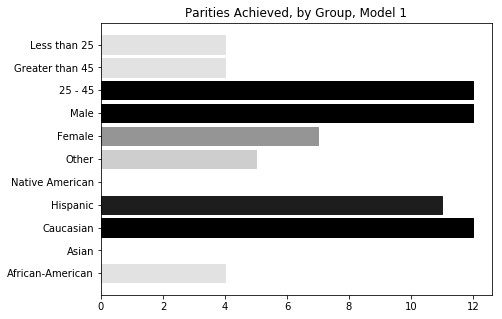

In [311]:
parity_count(fdf)

In [751]:
def plot_fairness_group(fairness_table, group_metric, ax=None, ax_lim = None, title=False, label_dict=None):
    '''
    This function plots absolute group metrics as indicated by the config file, colored 
        based on calculated parity
    :param fairness_table: A fairness table
    :param group_metric: The fairness metric to plot. Must be a column in the fairness_table.
    :param ax: A matplotlib Axis. If not passed a new figure will be created.
    :param title: Whether a title should be added to the plot. Default is True. 
    :param label_dict: (Optional) Dictionary of replacement values for data. Default is None.
    :return: matplotlib.Axis
    '''
    
    if any(fairness_table[group_metric].isnull()):
        raise IOError(f"Cannot plot {group_metric}, has NaN values.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    height_of_bar = 1
    attributes = fairness_table.attribute_name.unique()
    tick_indices = []
    next_bar_height = 0
    label_position_values = list(fairness_table[group_metric].values)
    
    # Define mapping for condiitonal coloring based on fairness determinations 
    metric_parity_mapping = {'tpr': 'TPR Parity', 
                             'tnr': 'TNR Parity', 
                             'for': 'FOR Parity', 
                             'fdr': 'FDR Parity', 
                             'fpr': 'FPR Parity', 
                             'fnr': 'FNR Parity', 
                             'npv': 'NPV Parity', 
                             'precision': 'Precision Parity', 
                             'ppr': 'Statistical Parity', 
                             'pprev': 'Impact Parity'}
    
    # Lock absolute value metric plot x-axis to (0, 1)
    if not ax_lim:
        ax_lim = 1
    ax.set_xlim(0, ax_lim)
    
    for attribute in attributes:
        attribute_data = fairness_table.loc[
            fairness_table['attribute_name'] == attribute]
        values = attribute_data[group_metric].values
        
        # apply red for "False" fairness determinations and green for "True" determinations
        cb_green = '#1b7837'
        cb_red = '#a50026'
        measure = metric_parity_mapping[group_metric]
        measure_colors = [cb_green if val == True else cb_red for val in attribute_data[measure]]
        # Set white text for red bars and black text for green bars
        label_colors = [(0,0,0,1) if val == True else (1,1,1,1) for val in attribute_data[measure]]
        
        attribute_indices = np.arange(next_bar_height,
                                      next_bar_height + attribute_data.shape[0],
                                      step=height_of_bar)
        attribute_tick_location = float((min(attribute_indices) + max(attribute_indices) + height_of_bar)) / 2
        h_attribute = ax.barh(attribute_indices,
                              width=values,
                              color=measure_colors,
                              align='edge', edgecolor='grey', alpha=0.8)

        if label_dict:
            labels = [label if label not in label_dict.keys() else label_dict[label] for label in attribute_data['attribute_value'].values]
        else:
            labels = attribute_data['attribute_value'].values
                    
        for y, label, value, text_color in zip(attribute_indices, labels, values, label_colors):
                next_position = label_position_values.pop(0)
                
                if ax_lim < 3:
                    CHAR_PLACEHOLDER = 0.03
                else:
                    CHAR_PLACEHOLDER = 0.25
                    
                label_length = len(label) * CHAR_PLACEHOLDER
                max_val_length = 7 * CHAR_PLACEHOLDER
                indent_length = ax_lim * 0.025
                
                if ((indent_length + label_length) < (next_position - indent_length)) & ((next_position + indent_length + max_val_length) < (ax_lim - indent_length)):
                    # bar long enough for label, enough space after bar for value
                    ax.text(next_position + (ax_lim * 0.05), y + float(height_of_bar) / 2, 
                        f"{value:.2f}", fontsize=12, verticalalignment='top')
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        label, fontsize=11, verticalalignment='top', color=text_color)
                   
                elif (next_position + indent_length + max_val_length) > (ax_lim - indent_length):
                     # case when bar too long for labels after bar, print all text in bar
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=11, verticalalignment='top', color=text_color)
                
                else:
                    # case when bar too small for labels inside bar, print all text after bar
                    ax.text(next_position + indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=12, verticalalignment='top')
                
        tick_indices.append((attribute, attribute_tick_location))
        next_bar_height = max(attribute_indices) + 2 * height_of_bar

    ax.yaxis.set_ticks(list(map(lambda x: x[1], tick_indices)))
    ax.yaxis.set_ticklabels(list(map(lambda x: x[0], tick_indices)), fontsize=14)
    
    ax.set_xlabel('Absolute Metric Magnitude')

    if title:
        ax.set_title(f"{group_metric.upper()}", fontsize=20)

    return ax

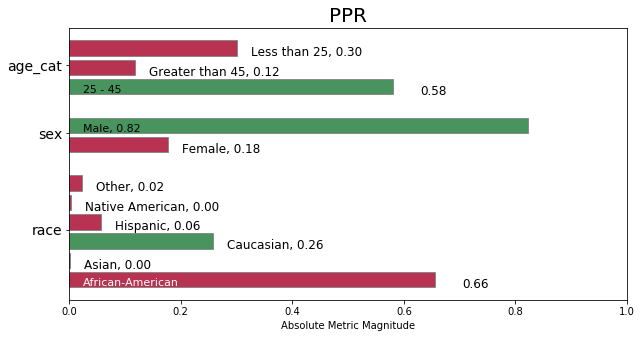

In [752]:
plot_fairness_group(fdf, group_metric='ppr', title=True, label_dict={})
plt.show()

In [772]:
def plot_fairness_disparity(fairness_table, group_metric, ax=None, ax_lim = None, title=False, label_dict=None):
    '''
    This function plots absolute group metrics as indicated by the config file, colored 
        based on calculated parity
    :param fairness_table: A fairness table
    :param group_metric: The fairness metric to plot. Must be a column in the fairness_table.
    :param ax: A matplotlib Axis. If not passed a new figure will be created.
    :param title: Whether a title should be added to the plot. Default is True. 
    :param label_dict: (Optional) Dictionary of replacement values for data. Default is None.
    :return: matplotlib.Axis
    '''
    
    if any(fairness_table[group_metric].isnull()):
        raise IOError(f"Cannot plot {group_metric}, has NaN values.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    height_of_bar = 1
    attributes = fairness_table.attribute_name.unique()
    tick_indices = []
    next_bar_height = 0
    label_position_values = list(fairness_table[group_metric].values)
    
    # Define mapping for condiitonal coloring based on fairness determinations 
    metric_parity_mapping = {'ppr_disparity': 'Statistical Parity', 
                             'pprev_disparity': 'Impact Parity',
                             'precision_disparity': 'Precision Parity',
                             'fdr_disparity': 'FDR Parity', 
                             'for_disparity': 'FOR Parity',
                             'fpr_disparity': 'FPR Parity',
                             'fnr_disparity': 'FNR Parity',
                             'tpr_disparity': 'TPR Parity',
                             'tnr_disparity': 'TNR Parity',
                             'npv_disparity': 'NPV Parity'}
    
    if not ax_lim:
        ax_lim = nearest_quartile(fairness_table[group_metric].max()) + 0.1
    ax.set_xlim(0, ax_lim)
    
    for attribute in attributes:
        attribute_data = fairness_table.loc[
            fairness_table['attribute_name'] == attribute]
        values = attribute_data[group_metric].values
        
        # apply red for "False" fairness determinations and green for "True" determinations
        cb_green = '#1b7837'
        cb_red = '#a50026'
        measure = metric_parity_mapping[group_metric]
        measure_colors = [cb_green if val == True else cb_red for val in attribute_data[measure]]
        # Set white text for red bars and black text for green bars
        label_colors = [(0,0,0,1) if val == True else (1,1,1,1) for val in attribute_data[measure]]
        
        attribute_indices = np.arange(next_bar_height,
                                      next_bar_height + attribute_data.shape[0],
                                      step=height_of_bar)
        attribute_tick_location = float((min(attribute_indices) + max(attribute_indices) + height_of_bar)) / 2
        h_attribute = ax.barh(attribute_indices,
                              width=values,
                              color=measure_colors,
                              align='edge', edgecolor='grey', alpha=0.8)

        if label_dict:
            labels = [label if label not in label_dict.keys() else label_dict[label] for label in attribute_data['attribute_value'].values]
        else:
            labels = attribute_data['attribute_value'].values
                    
        for y, label, value, text_color in zip(attribute_indices, labels, values, label_colors):
                next_position = label_position_values.pop(0)
                
                if ax_lim < 3:
                    CHAR_PLACEHOLDER = 0.03
                else:
                    CHAR_PLACEHOLDER = 0.25
                    
                label_length = len(label) * CHAR_PLACEHOLDER
                max_val_length = 7 * CHAR_PLACEHOLDER
                indent_length = ax_lim * 0.025
                
                if ((indent_length + label_length) < (next_position - indent_length)) & ((next_position + indent_length + max_val_length) < (ax_lim - indent_length)):
                    # bar long enough for label, enough space after bar for value
                    ax.text(next_position + (ax_lim * 0.05), y + float(height_of_bar) / 2, 
                        f"{value:.2f}", fontsize=12, verticalalignment='top')
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        label, fontsize=11, verticalalignment='top', color=text_color)
                   
                elif (next_position + indent_length + max_val_length) > (ax_lim - indent_length):
                     # case when bar too long for labels after bar, print all text in bar
                    ax.text(indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=11, verticalalignment='top', color=text_color)
                
                else:
                    # case when bar too small for labels inside bar, print all text after bar
                    ax.text(next_position + indent_length, y + float(height_of_bar) / 2, 
                        f"{label}, {value:.2f}", fontsize=12, verticalalignment='top')
                
        tick_indices.append((attribute, attribute_tick_location))
        next_bar_height = max(attribute_indices) + 2 * height_of_bar

    ax.yaxis.set_ticks(list(map(lambda x: x[1], tick_indices)))
    ax.yaxis.set_ticklabels(list(map(lambda x: x[0], tick_indices)), fontsize=14)
    
    ax.set_xlabel('Absolute Metric Magnitude')

    if title:
        ax.set_title(f"{group_metric.upper()}", fontsize=20)

    return ax

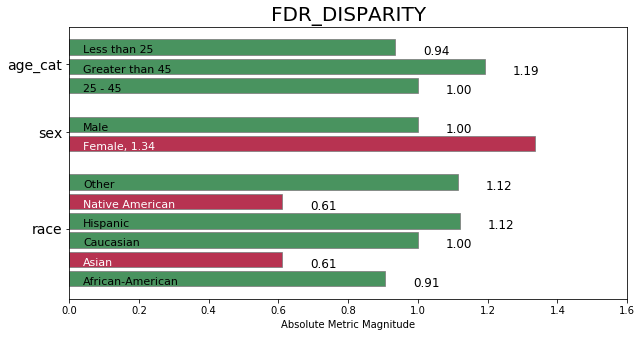

In [773]:
m = plot_fairness_disparity(fdf, group_metric='fdr_disparity', title=True, label_dict={})

In [780]:
def plot_multiple(data_table, plot_fcn, plot_group_metrics=None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    """
    This function plots disparities as indicated by the config file, colored 
        based on calculated parity 
    :param data_table: Output of group.get_crosstabs, bias.get_disparity, or fairness.get_fairness functions
    :param plot_group_metrics: which metric(s) to plot, or 'all.'
        If this value is null, will plot: Predicted Prevalence (pprev), Predicted Positive Rate (ppr), 
        False Discovery Rate (fdr), False Omission Rate (for), False Positve Rate (fpr), 
        False Negative Rate (fnr), (or related disparity measures).
    :param fillzeros: Should null values be filled with zeros. Default is True.
    :param show_figure: Whether to show figure (plt.show()). Default is True.
    :param title: Whether to display a title on each plot. Default is True.
    :param label_dict: Dictionary of label replacements. Default is None.
    
    :return: Returns a figure
    """
    if fillzeros:
        data_table = data_table.fillna(0)
    
    if plot_fcn in [plot_fairness_group, plot_group_metric]:
        if not plot_group_metrics:
            plot_group_metrics = ['pprev', 'ppr', 'fdr', 'for','fpr','fnr']

    #         plot_group_metrics = list(set(self.input_group_metrics) & set(data_table.columns))
        elif plot_group_metrics == 'all':
            plot_group_metrics = ['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 
                                  'npv', 'precision', 'ppr', 'pprev']
        
        ax_lim = 1
        
    elif plot_fcn in [plot_fairness_disparity, plot_disparity]:
        if not plot_group_metrics:
#         plot_group_metrics = list(set(self.input_group_metrics) & set(data_table.columns))
            plot_group_metrics = ['pprev_disparity', 'ppr_disparity', 'fdr_disparity', 
                         'for_disparity','fpr_disparity','fnr_disparity']
        elif plot_group_metrics == 'all':
            plot_group_metrics = list(data_table.columns[data_table.columns.str.contains('disparity')])
        
        ax_lim = min(10, nearest_quartile(max(data_table[plot_group_metrics].max())) + 0.1)

   
    num_metrics = len(plot_group_metrics)
    rows = math.ceil(num_metrics / ncols)
    if ncols == 1 or (num_metrics % ncols == 0):
        axes_to_remove = 0
    else:
        axes_to_remove = ncols - (num_metrics % ncols)
    
    assert (0 < rows <= num_metrics),"Plot must have at least one row. Please update number of columns ('ncols') or list of metrics to be plotted ('plot_group_metrics')."
    assert (0 < ncols <= num_metrics),"Plot must have at least one column, and no more columns than metrics. Please update number of columns ('ncols') or list of metrics to be plotted ('plot_group_metrics')."
    
    total_plot_width = 25
    
    fig, axs = plt.subplots(nrows=rows, ncols=ncols, figsize=(total_plot_width, 6 * rows), sharey=True, gridspec_kw={'wspace':0.075, 'hspace':0.25})
    
    # set a different metric to be plotted in each subplot
    ax_col = 0
    ax_row = 0
    
    for group_metric in plot_group_metrics:    
        if (ax_col >= ncols) & ((ax_col + 1) % ncols) == 1:
            ax_row += 1
            ax_col = 0

        if rows == 1:
            current_subplot = axs[ax_col]
        
        elif ncols == 1:
            current_subplot = axs[ax_row]
            ax_row += 1
        else:
            current_subplot = axs[ax_row, ax_col]

        plot_fcn(data_table, group_metric=group_metric, ax=current_subplot, 
                 ax_lim=ax_lim, title=title, label_dict=label_dict)
        ax_col += 1

    # disable axes not being used
    if axes_to_remove > 0:
        for i in np.arange(axes_to_remove):
            axs[-1, -(i+1)].axis('off')
    
    if show_figure:
        plt.show()
    return fig

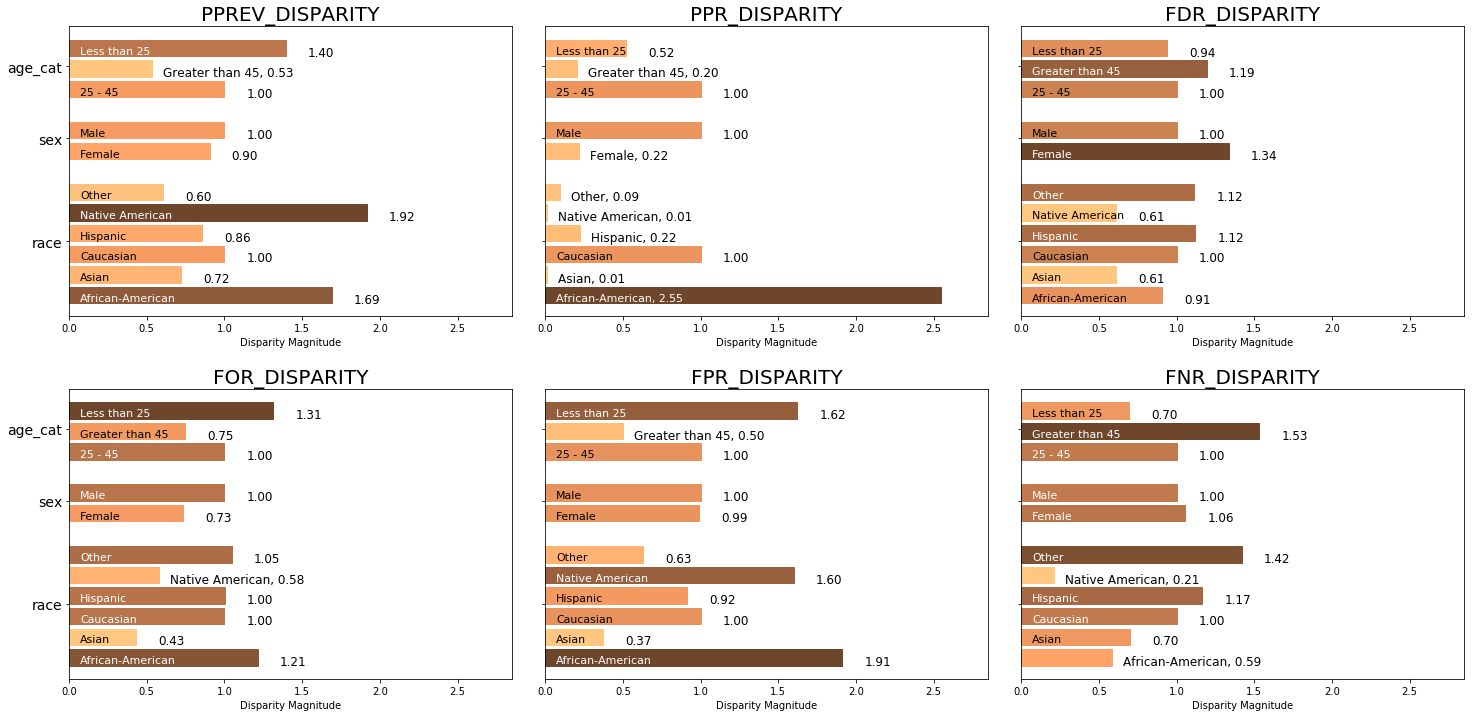

In [781]:
m = plot_multiple(fdf, plot_fcn=plot_disparity, title=True, label_dict={})

In [782]:
def plot_fairness_disparity_all(data_table, plot_group_metrics=None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    return plot_multiple(data_table, plot_fcn=plot_fairness_disparity, plot_group_metrics=plot_group_metrics, fillzeros=fillzeros, title=title, ncols=ncols, label_dict=label_dict, show_figure=show_figure)

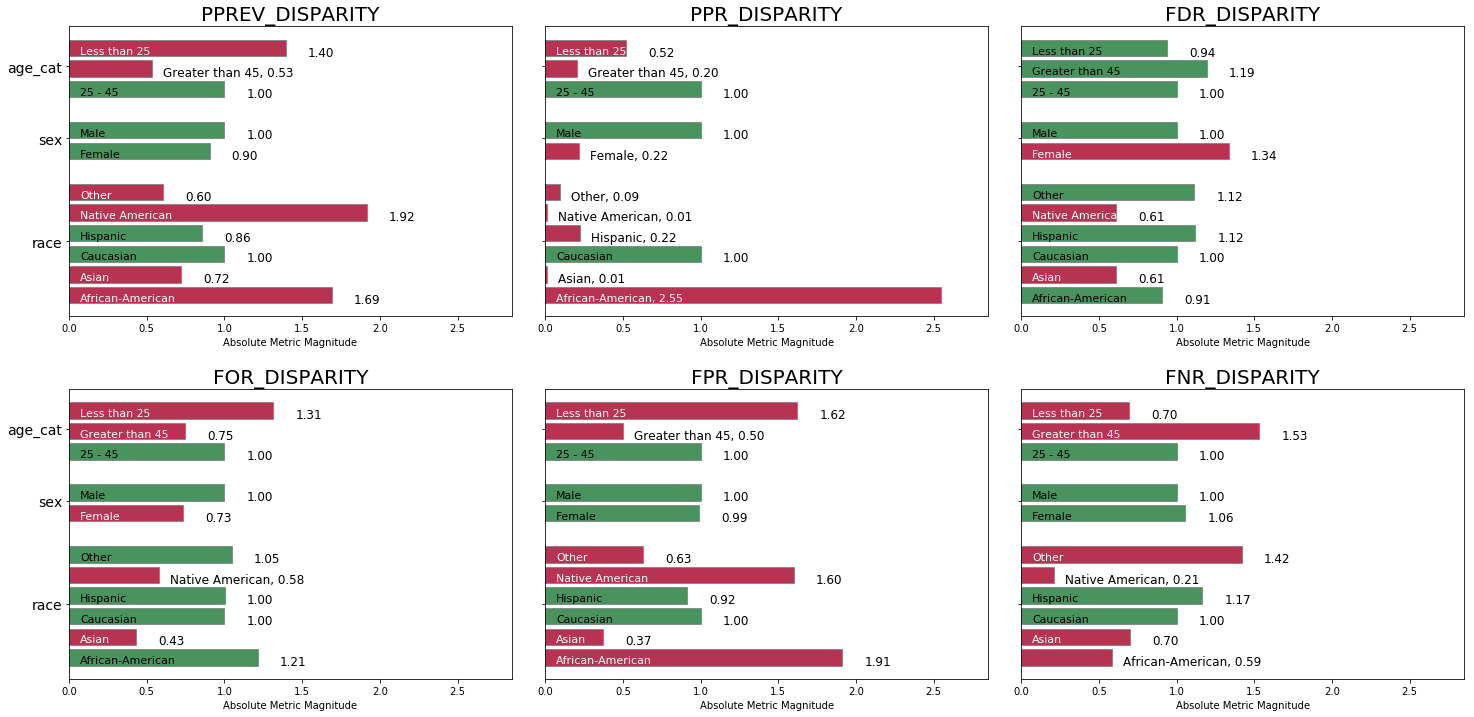

In [783]:
t = plot_fairness_disparity_all(fdf)

In [784]:
def plot_fairness_group_all(data_table, plot_group_metrics=None, fillzeros=True, title=True, ncols=3, label_dict=None, show_figure=True):
    return plot_multiple(data_table, plot_fcn=plot_fairness_group, plot_group_metrics=plot_group_metrics, fillzeros=fillzeros, title=title, ncols=ncols, label_dict=label_dict, show_figure=show_figure)

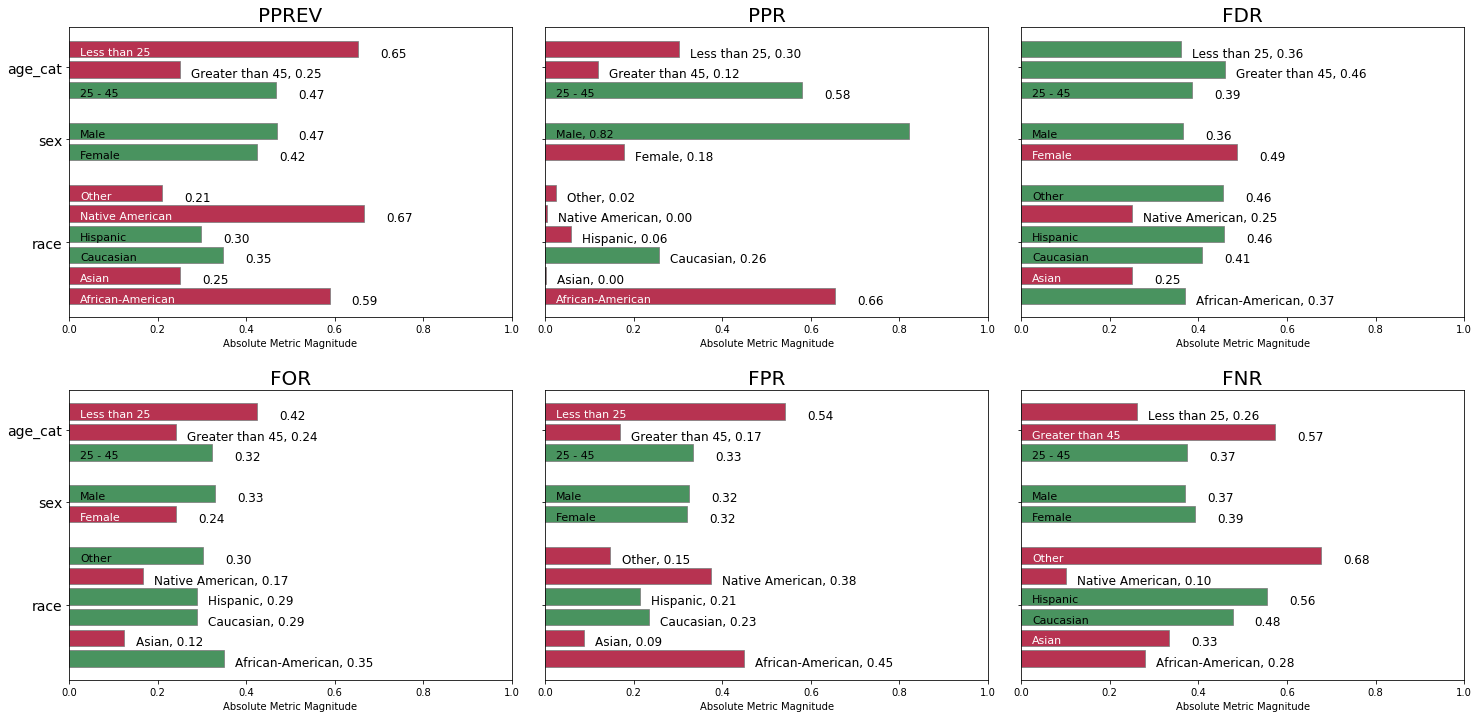

In [785]:
fg = plot_fairness_group_all(fdf)

__Interpreting parity__ In this case, our base groups are Caucasian for race, Male for gender, and 25-45 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

On the other hand, African-Americans are roughly twice as likely to have false positives and 40 percent less likely to false negatives. In real terms, 44.8% of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 23.4% of Caucasian non-reoffenders. This is unfair and is marked False below.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.